In [1]:
# some necessary imports
import os
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
df = pd.read_csv('balanced-sarcasm.csv')

In [3]:
df['label'].value_counts()

1    505413
0    505413
Name: label, dtype: int64

### Dataset is really fully balanced!!! 

In [4]:
# Before start to parse tf-idf matrix let's try to find some dependiencies
# Defining of sarcasm fraction distribution per subreddit is the most evidence way
df_crosstab = pd.crosstab(df['subreddit'], df['label'])
df_crosstab['sarcasm fraction'] = df_crosstab[1] / (df_crosstab[1] + df_crosstab[0])
df_crosstab['count'] = df_crosstab[0] + df_crosstab[1]
# To avoid 100% fractions for the small subreddit let's sort it by special way
df_crosstab_correct = df_crosstab[df_crosstab['count'] > 100].sort_values(by='sarcasm fraction', ascending=False)

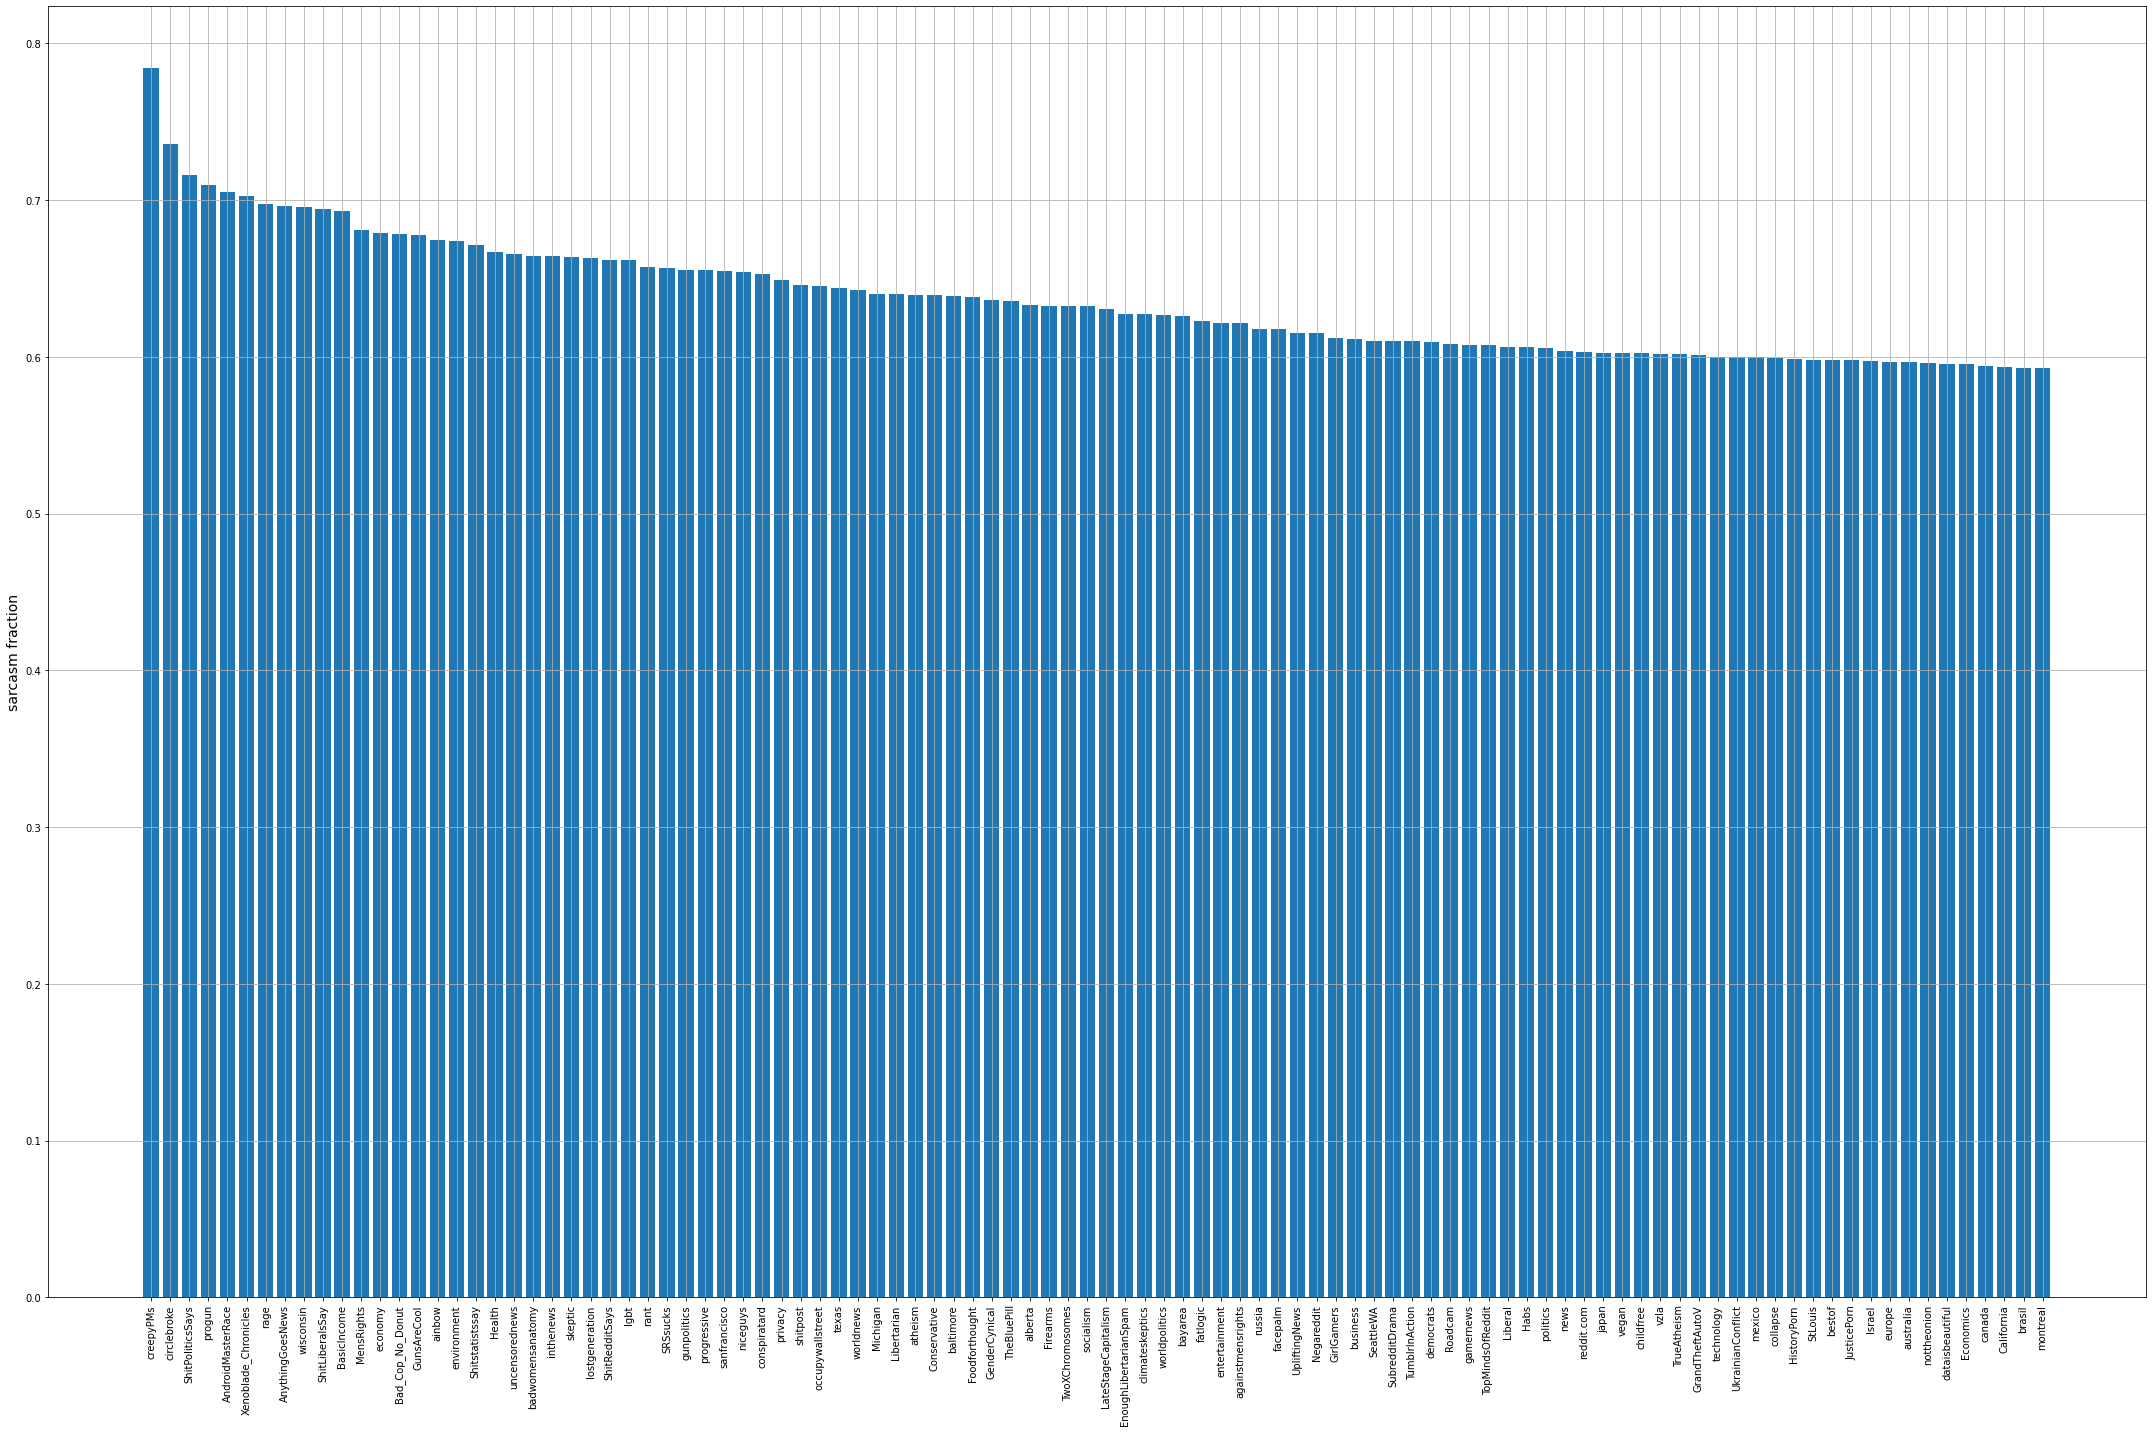

In [5]:
# visualizing
plt.figure(figsize=(30, 20))
plt.bar(df_crosstab_correct.index[:100], df_crosstab_correct['sarcasm fraction'][:100])
plt.grid(True)
plt.xticks(rotation=90)
plt.ylabel('sarcasm fraction', fontsize=14)
plt.tight_layout()

### What are the sonorous names of subreddits with maximum sarcasm fraction:-). For example: "ShitPoliticSays", "Bad_Cop_No_Donut", "badwomensanatomy", "ShitLiberalSays" etc.
### So it may be useful to make an OneHotEncoding transform for this column before training.

In [6]:
# What dependance between comment's score and sarcasm
df_crosstab_scoring = pd.crosstab(df['score'], df['label'])
df_crosstab_scoring['sarcasm fraction'] = df_crosstab_scoring[1] / (df_crosstab_scoring[1] + df_crosstab_scoring[0])
df_crosstab_scoring['count'] = df_crosstab_scoring[0] + df_crosstab_scoring[1]
df_crosstab_correct_scoring = df_crosstab_scoring[df_crosstab_scoring['count'] > 100]

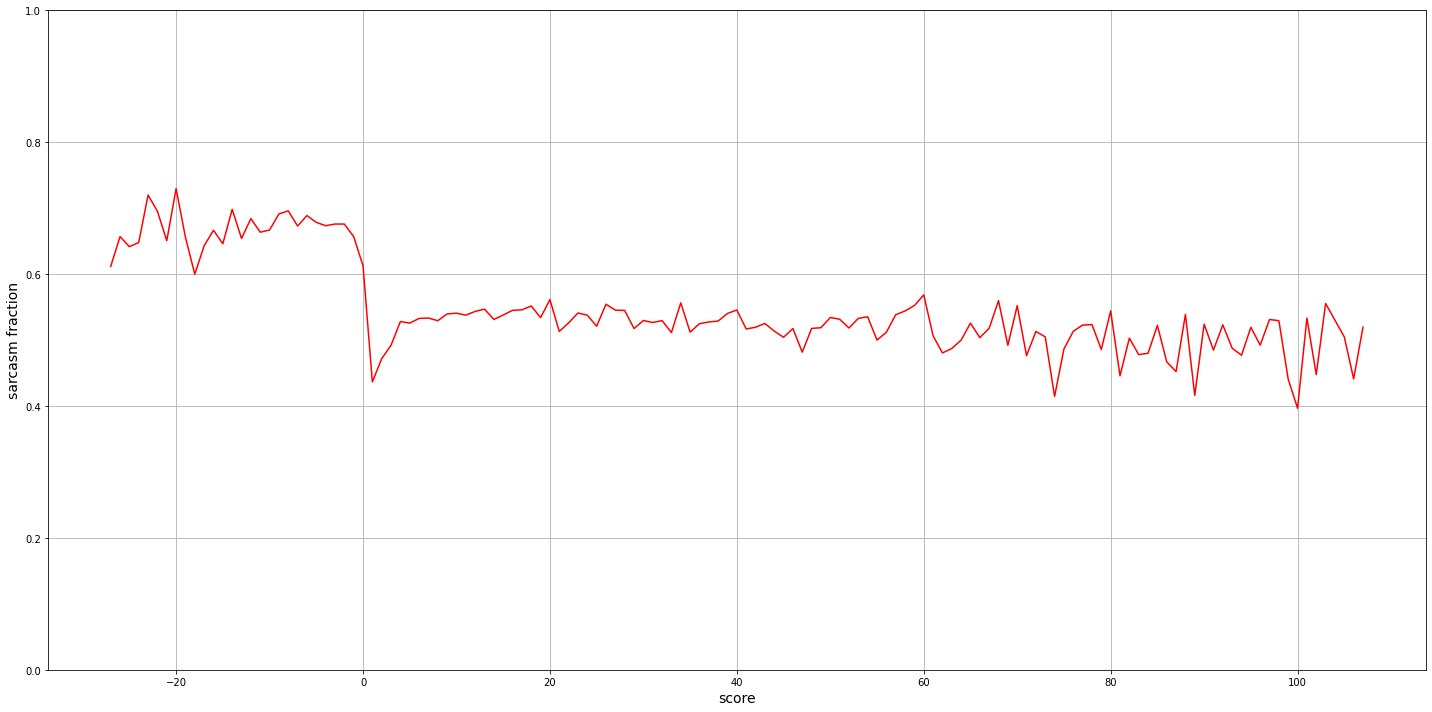

In [7]:
plt.figure(figsize=(20, 10))
plt.plot(df_crosstab_correct_scoring.sort_index().index,
         df_crosstab_correct_scoring.sort_index()['sarcasm fraction'],
        color='red')
plt.grid(True)
plt.ylim(((0, 1)))
plt.xlabel('score', fontsize=14)
plt.ylabel('sarcasm fraction', fontsize=14)
plt.tight_layout()

### Almost discrete distribution)
### Mean sarcasm fraction of negative score comments is 0.67, in the same time mean sarcasm fraction of positive score comments is 0.55
### Just a labeling will help!!!

### Before let's see some more metrics - sarcasm fraction per: month, day of month, hour 

In [8]:
df['month'] = df['date'].str.split('-', n=1, expand=True)[1]

In [9]:
month_cross = pd.crosstab(df['month'], df['label'])
month_cross['count'] = month_cross[0] + month_cross[1]
month_cross['sarcasm_frac'] = month_cross[1]/(month_cross[0] + month_cross[1])

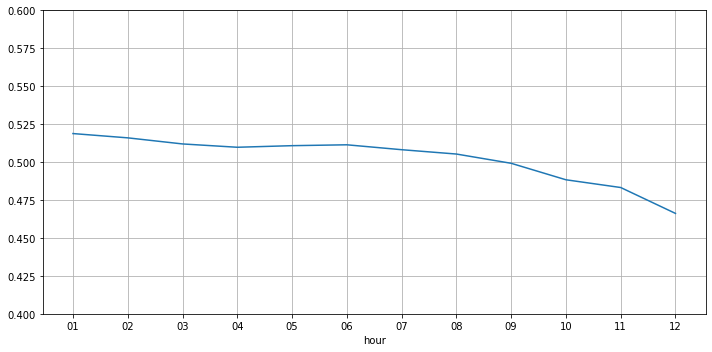

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(month_cross.index, month_cross.sarcasm_frac)
plt.grid(True)
plt.ylim((0.4, 0.6))
plt.xlabel('hour')
plt.tight_layout()

In [11]:
df['day_of_month'] = df['created_utc'].str.split(' ', n=1, expand=True)[0].str.split('-', n=2, expand=True)[2]

In [12]:
day_of_month_cross = pd.crosstab(df['day_of_month'], df['label'])
day_of_month_cross['count'] = day_of_month_cross[0] + day_of_month_cross[1]
day_of_month_cross['sarcasm_frac'] = day_of_month_cross[1]/(day_of_month_cross[0] + day_of_month_cross[1])

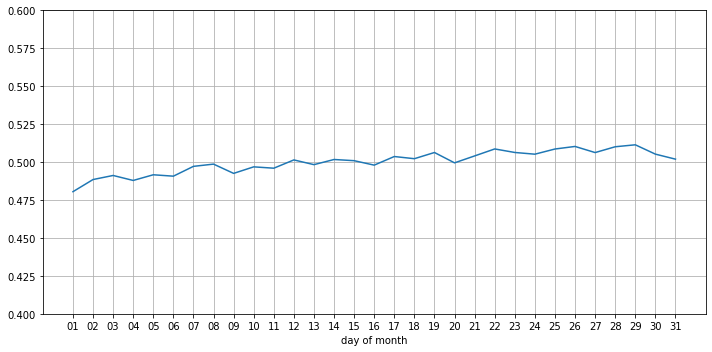

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(day_of_month_cross.index, day_of_month_cross.sarcasm_frac)
plt.grid(True)
plt.ylim((0.4, 0.6))
plt.xlabel('day of month')
plt.tight_layout()

In [14]:
df['hour'] = df['created_utc'].str.split(' ', n=1, expand=True)[1].str.split(':', n=2, expand=True)[0]

In [15]:
hour_cross = pd.crosstab(df['hour'], df['label'])
hour_cross['count'] = hour_cross[0] + hour_cross[1]
hour_cross['sarcasm_frac'] = hour_cross[1]/(hour_cross[0] + hour_cross[1])

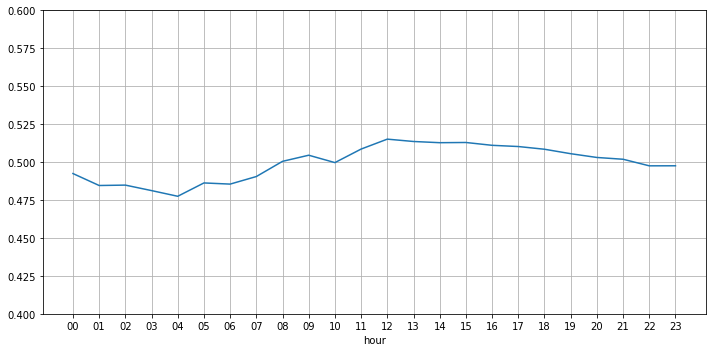

In [16]:
plt.figure(figsize=(10, 5))
plt.plot(hour_cross.index, hour_cross.sarcasm_frac)
plt.grid(True)
plt.ylim((0.4, 0.6))
plt.xlabel('hour')
plt.tight_layout()

### Almost nothing significant

In [17]:
#Time to play with word's bigram matrix!
tf_vector_two_gramm = TfidfVectorizer(ngram_range=(2, 2), max_features=50000, max_df=2)
ttw_sarcasm = tf_vector_two_gramm.fit_transform(df[df['label']==1].loc[:10000]['comment'].astype('U')).toarray()
name_sarcasm = np.array(tf_vector_two_gramm.get_feature_names())
ttw_sarcasm_not = tf_vector_two_gramm.fit_transform(df[df['label']==0].loc[:10000]['comment'].astype('U')).toarray()
name_sarcasm_not = np.array(tf_vector_two_gramm.get_feature_names())

In [18]:
ttw_sarcasm = ttw_sarcasm.sum(axis=0)
ttw_sarcasm_not = ttw_sarcasm_not.sum(axis=0)

In [19]:
ttw_sarcasm_arg = ttw_sarcasm.argsort()
ttw_sarcasm.sort()
ttw_sarcasm_not_arg = ttw_sarcasm_not.argsort()
ttw_sarcasm_not.sort()

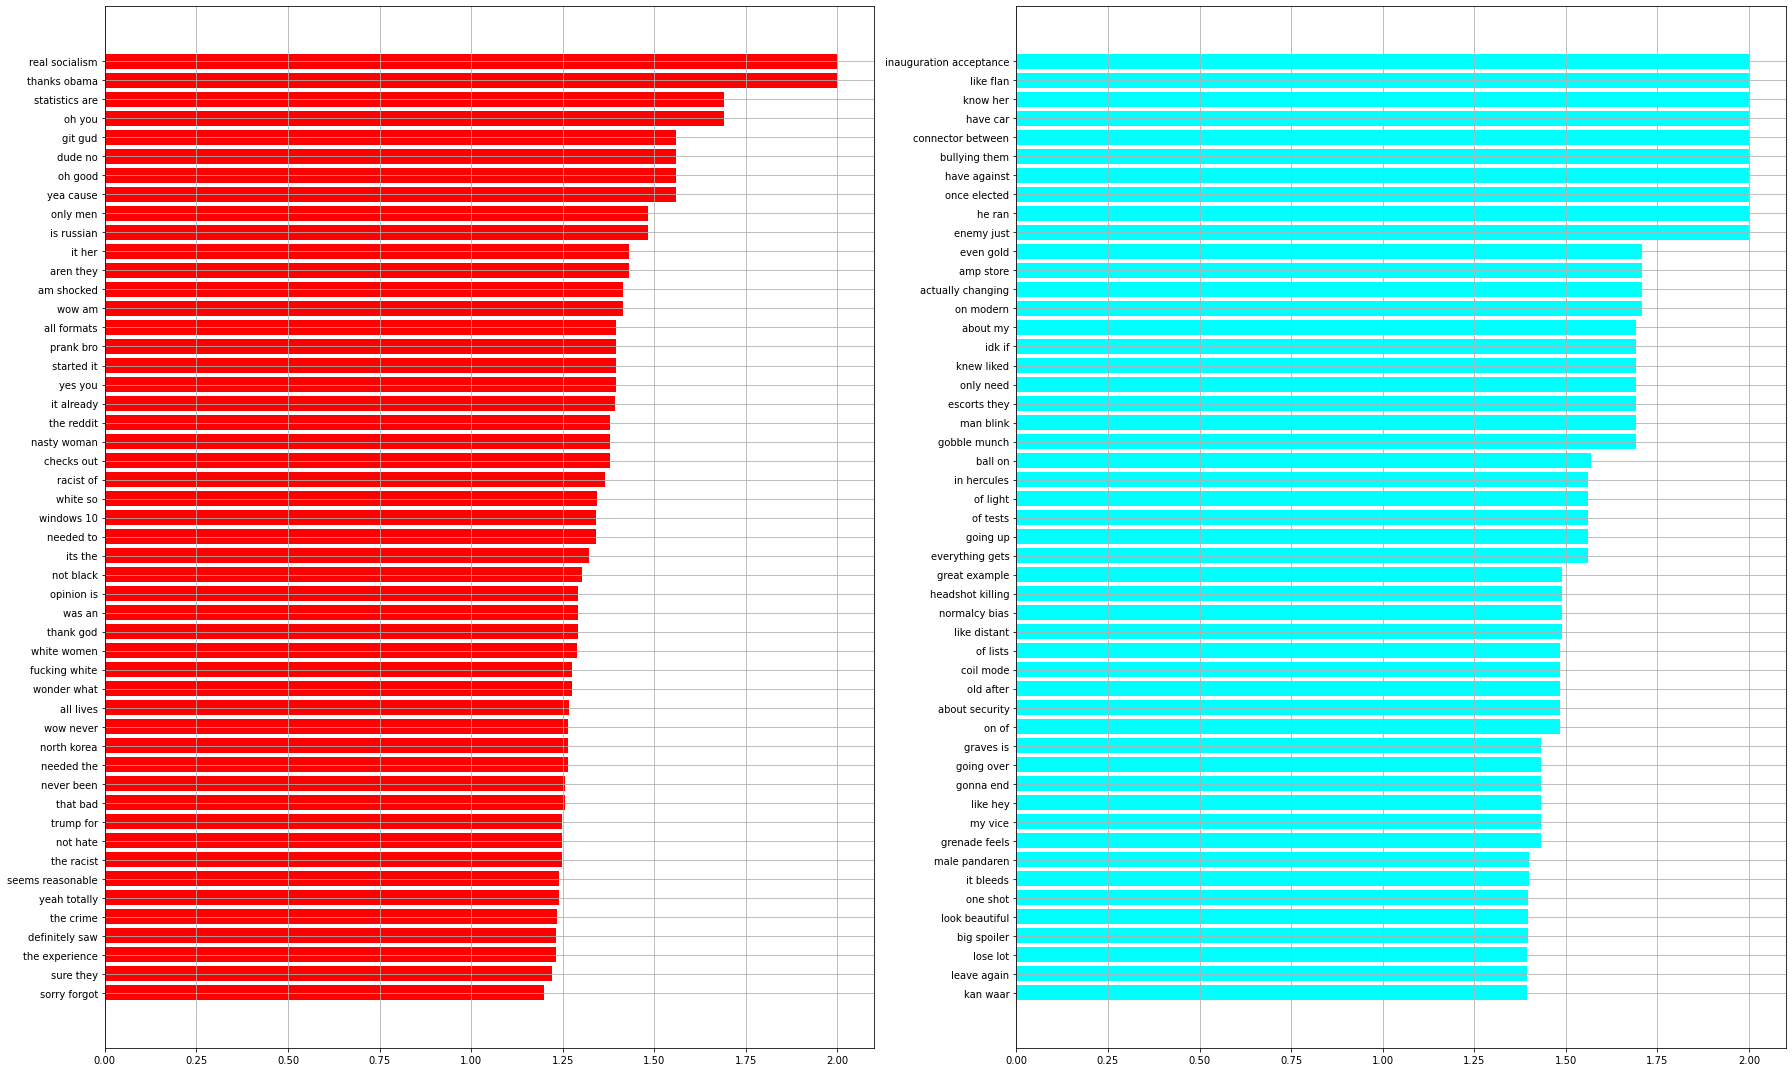

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(25, 15))
ax[0].grid(True)
ax[0].barh(name_sarcasm[ttw_sarcasm_arg[-50:]],
         ttw_sarcasm[-50:], color='red')
ax[1].grid(True)
ax[1].barh(name_sarcasm_not[ttw_sarcasm_arg[-50:]],
         ttw_sarcasm_not[-50:], color='cyan')
plt.tight_layout()

### The histogramms is quite true - "thanks obama", "dude no", "git gud", "prank bro" vs "inaguration acceptance", "like distant" and etc.

In [21]:
#Since a dataset quite balanced it's possible to use train_test_split instead of StratifiedKFold
X_train, X_test, Y_train, Y_test = train_test_split(df.drop(labels=['label'], axis=1), df['label'], train_size=0.7)

In [22]:
# build bigrams, put a limit on maximal number of features
# and minimal word frequency
tf_idf = TfidfVectorizer(ngram_range=(1, 2), max_features=50000, min_df=2)
# multinomial logistic regression a.k.a softmax classifier
logit = LogisticRegression(C=0.97, n_jobs=-1, solver='lbfgs',
                           random_state=17, verbose=1)
# sklearn's pipeline
tfidf_logit_pipeline = Pipeline([('tf_idf', tf_idf),
                                 ('logit', logit)])

In [23]:
tfidf_logit_pipeline.fit(X_train['comment'].astype('U'), Y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    9.1s finished


Pipeline(steps=[('tf_idf',
                 TfidfVectorizer(max_features=50000, min_df=2,
                                 ngram_range=(1, 2))),
                ('logit',
                 LogisticRegression(C=0.97, n_jobs=-1, random_state=17,
                                    verbose=1))])

In [24]:
tfidf_logit_pipeline.score(X_train['comment'].astype('U'), Y_train)

0.7501165949195707

In [25]:
tfidf_logit_pipeline.score(X_test['comment'].astype('U'), Y_test)

0.7202619638052024

In [26]:
from sklearn.metrics import roc_auc_score
roc_auc_score(Y_test, tfidf_logit_pipeline.predict_proba(X_test['comment'].astype('U'))[:, 1])

0.7914462908842318

### Quite good - let's try to improve our model by adding an somekind of OneHotEncoding for subreddits
### As it was written above we can use the OneHotEncoding to make a full matrix of any subreddit's names occurences for any instance.

In [27]:
#Check the number of uniqe subreddit's names
df['subreddit'].unique().shape

(14878,)

In [28]:
X_train.shape

(707578, 12)

### It will be too complicated to use this approach since the result matrix element count is 14878x707578=10527345484
### To reduce result's matrix we will use the CountVectorizer to parse all subreddit's names

In [29]:
from sklearn.feature_extraction.text import CountVectorizer
# build grams
tf_idf_subr = CountVectorizer(ngram_range=(1, 1))
# multinomial logistic regression a.k.a softmax classifier
logit_subr = LogisticRegression(C=0.93, n_jobs=-1, solver='lbfgs', 
                           random_state=17, verbose=1)
# sklearn's pipeline
tfidf_logit_pipeline_subr = Pipeline([('tf_idf_subr', tf_idf_subr),
                                 ('logit_subr', logit_subr)])

In [30]:
tfidf_logit_pipeline_subr.fit(X_train['subreddit'].astype('U'), Y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.7s finished


Pipeline(steps=[('tf_idf_subr', CountVectorizer()),
                ('logit_subr',
                 LogisticRegression(C=0.93, n_jobs=-1, random_state=17,
                                    verbose=1))])

In [31]:
tfidf_logit_pipeline_subr.score(X_train['subreddit'].astype('U'), Y_train)

0.5765201857604392

In [32]:
tfidf_logit_pipeline_subr.score(X_test['subreddit'].astype('U'), Y_test)

0.5693656677043212

In [33]:
roc_auc_score(Y_test, tfidf_logit_pipeline_subr.predict_proba(X_test['subreddit'].astype('U'))[:, 1])

0.5987760071135764

### Not bad. But we didn't consider another feature - score
### To simplify we will separate the feature "score+subreddit" and code the score by number, 
### which consists of more than 2 digits (for example - 1000)

In [34]:
df['score sign'] = np.sign(df['score']) + 1001
df['score sign'] = df['score sign'].apply(str)
df['score+subreddit'] = df['score sign'] + ' ' + df['subreddit']
#separate train and test dataset again
X_train, X_test, Y_train, Y_test = train_test_split(df.drop(labels=['label'], axis=1), df['label'], train_size=0.7)

In [35]:
#1000 - negative score
#1002 - positive score
#1001 - zero
df['score+subreddit']

0                    1002 politics
1                         1000 nba
2                         1002 nfl
3          1000 BlackPeopleTwitter
4          1002 MaddenUltimateTeam
                    ...           
1010821            1002 reddit.com
1010822               1002 climate
1010823               1002 atheism
1010824             1002 worldnews
1010825              1002 politics
Name: score+subreddit, Length: 1010826, dtype: object

In [36]:
#Split into test and train sets again
X_train, X_test, Y_train, Y_test = train_test_split(df.drop(labels=['label'], axis=1), df['label'], train_size=0.7)

In [37]:
#train a subreddit logit again
tfidf_logit_pipeline_subr.fit(X_train['score+subreddit'].astype('U'), Y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.8s finished


Pipeline(steps=[('tf_idf_subr', CountVectorizer()),
                ('logit_subr',
                 LogisticRegression(C=0.93, n_jobs=-1, random_state=17,
                                    verbose=1))])

In [38]:
tfidf_logit_pipeline_subr.score(X_train['score+subreddit'].astype('U'), Y_train)

0.5881598919129764

In [39]:
tfidf_logit_pipeline_subr.score(X_test['score+subreddit'].astype('U'), Y_test)

0.5828727642061943

In [40]:
roc_auc_score(Y_test, tfidf_logit_pipeline_subr.predict_proba(X_test['score+subreddit'].astype('U'))[:, 1])

0.6171306036482856

### It's already better - let's compose

In [41]:
#coefficients were chosen manually
result = 0.7*tfidf_logit_pipeline.predict_proba(X_test['comment'].astype('U'))[:, 1] +\
    0.3*tfidf_logit_pipeline_subr.predict_proba(X_test['score+subreddit'].astype('U'))[:, 1]

In [42]:
roc_auc_score(Y_test, result)

0.8229055356110925

In [44]:
result = result.round(0)

In [45]:
accuracy_score(Y_test, result)

0.7453008758507887

### Almost 75% - there is room to grow:-)

### Possible ways to get better:
1. Try to explore author names feature for dependency between length of the name, number of non-literal chars, upper & lowercase and sarcasm fraction
2. Use stemming or lemmatization of comments to decrease model complexity and increase accuracy, roc_auc score
3. Train that performed dataset with the gradient boosting (xgboost, lightGBM, etc.)